In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter
from derivative import dxdt

In [2]:
obs_data_dir = '../out/Screwdriving Model Experiments'
sen_data_dir = '../data/Screwdriving Model Experiments'
out_dir = '../out/sindy-data'

observation_file = 'preprocessed_observation_data.csv'
sensor_file = 'sensor_data.csv'
merged_file = 'merged_data.csv'

train_file = 'train_data.csv'
validation_file = 'val_data.csv'
test_file = 'test_data.csv'

subdirs = os.listdir(obs_data_dir)

/tmp/ipykernel_67180/441892201.py:51: FutureWarning: DataFrame.interpolate with method=backfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.interpolate(method='backfill', axis=0, inplace=True)


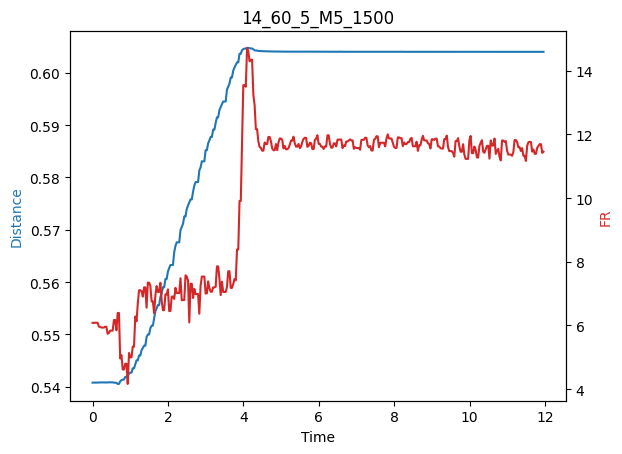

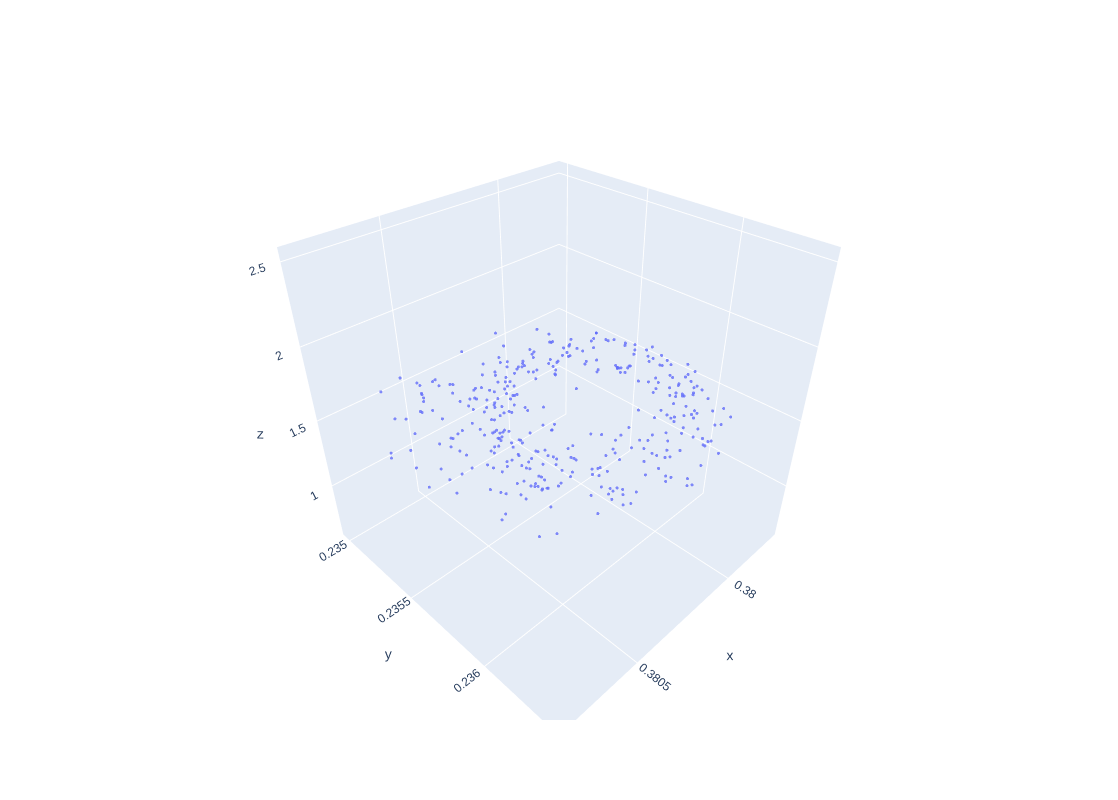

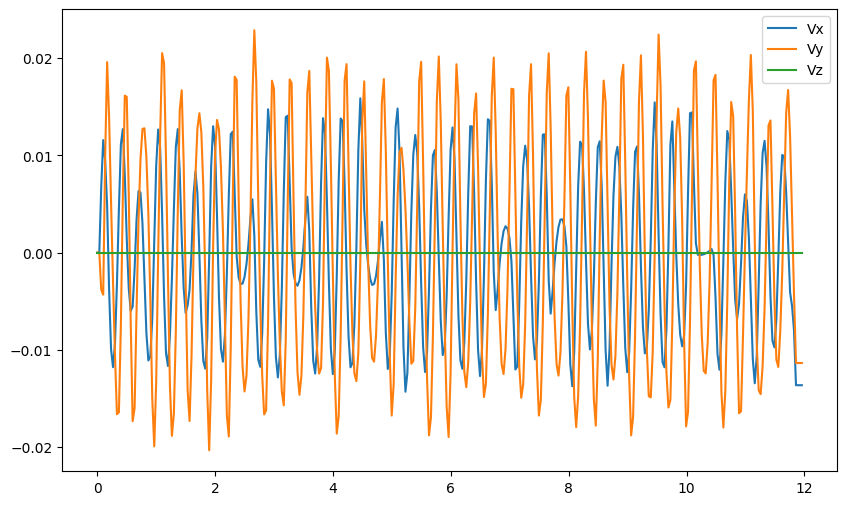

12_60_3_M4_2500  doesn't exist
17_60_8_M6_1500  doesn't exist


/tmp/ipykernel_67180/441892201.py:51: FutureWarning:

DataFrame.interpolate with method=backfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



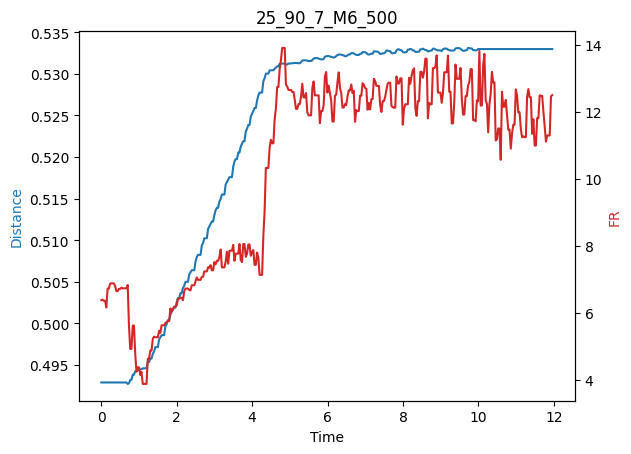

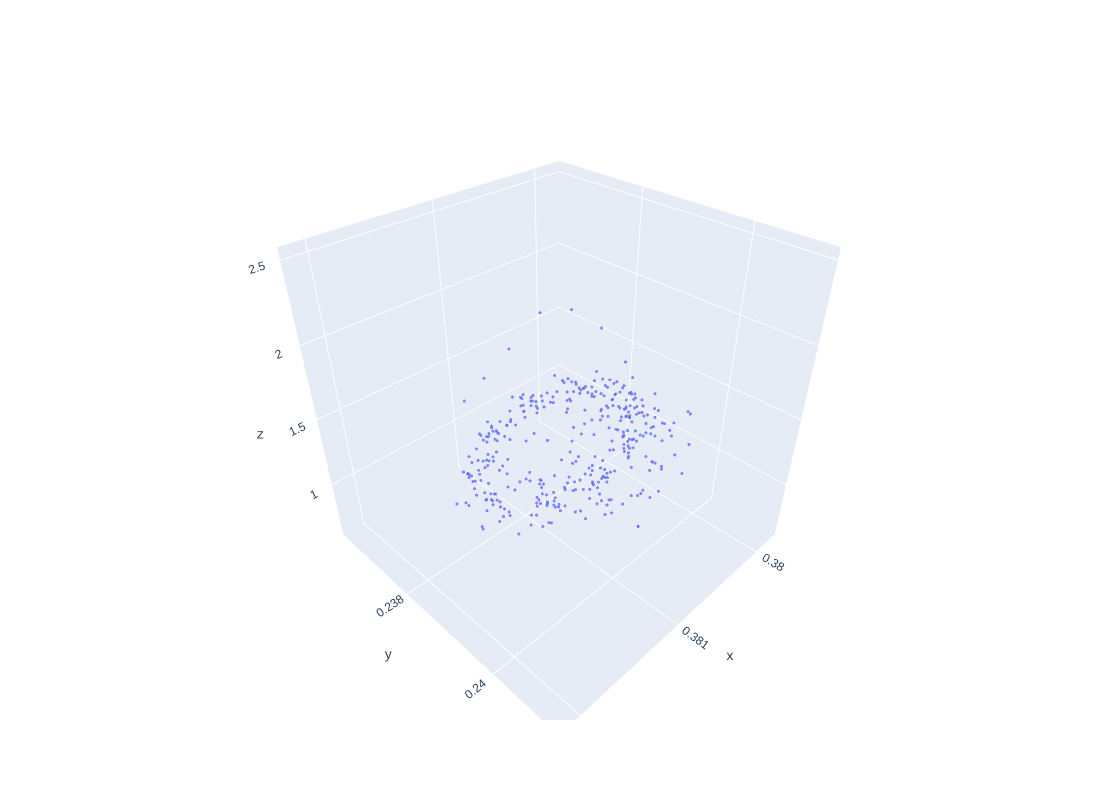

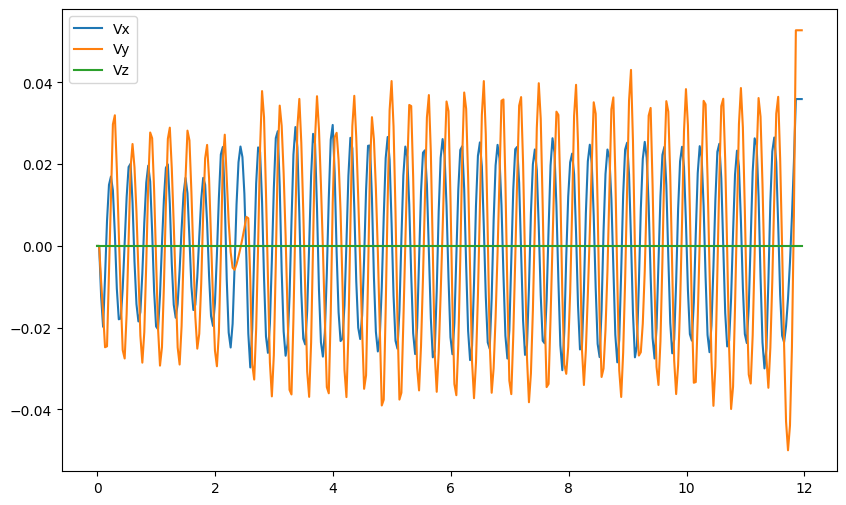

5_30_5_M5_1500  doesn't exist
15_60_6_M5_2500  doesn't exist


/tmp/ipykernel_67180/441892201.py:51: FutureWarning:

DataFrame.interpolate with method=backfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



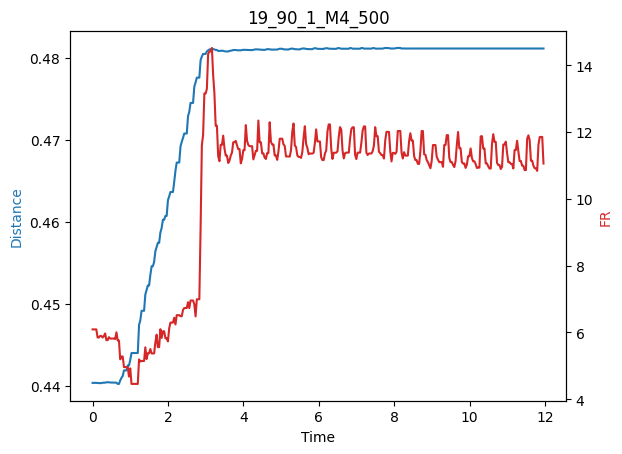

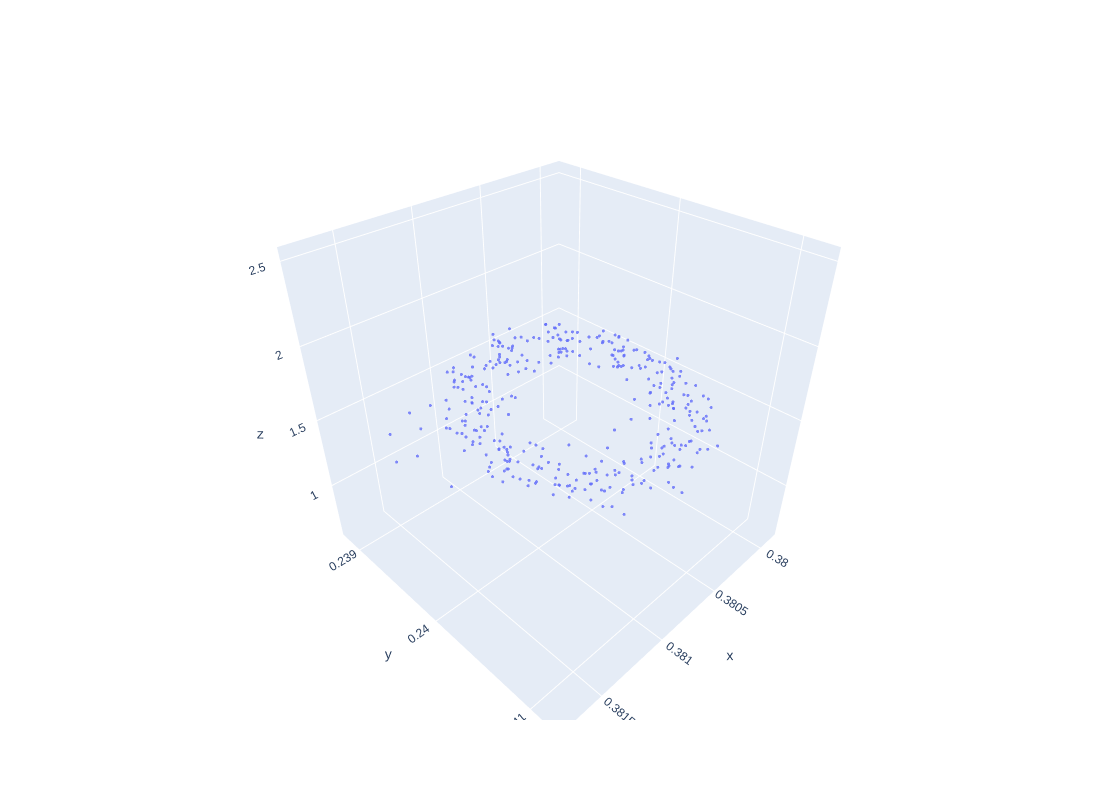

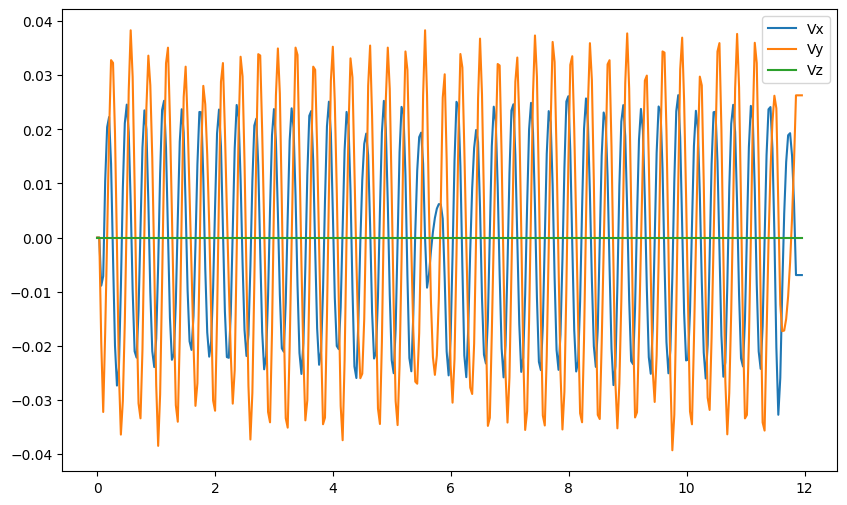

24_90_6_M5_2500  doesn't exist


/tmp/ipykernel_67180/441892201.py:51: FutureWarning:

DataFrame.interpolate with method=backfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



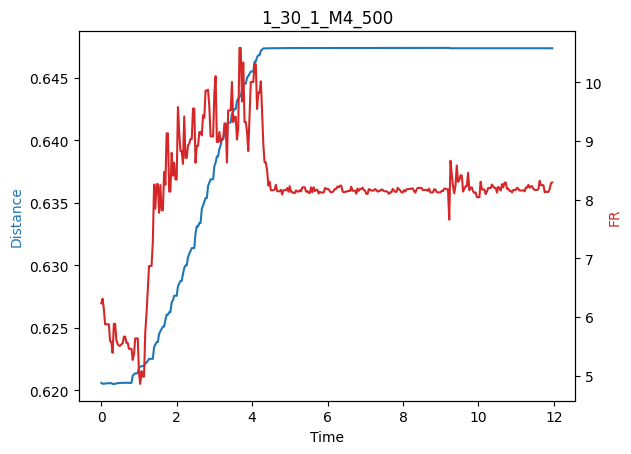

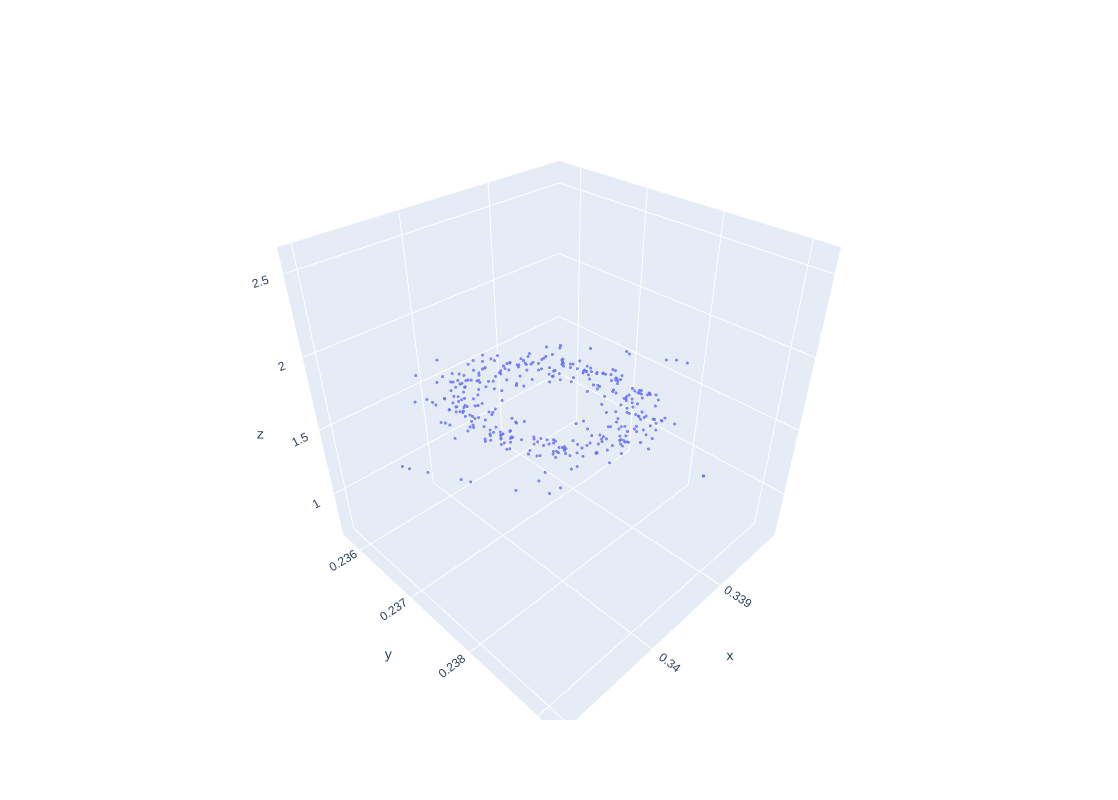

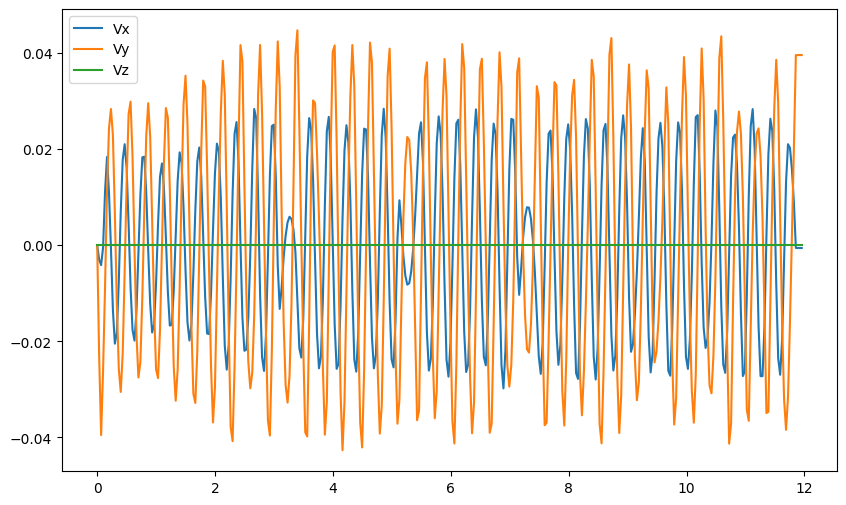

/tmp/ipykernel_67180/441892201.py:51: FutureWarning:

DataFrame.interpolate with method=backfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



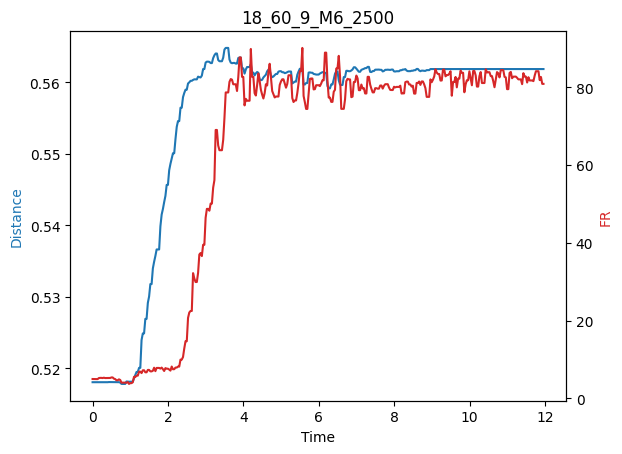

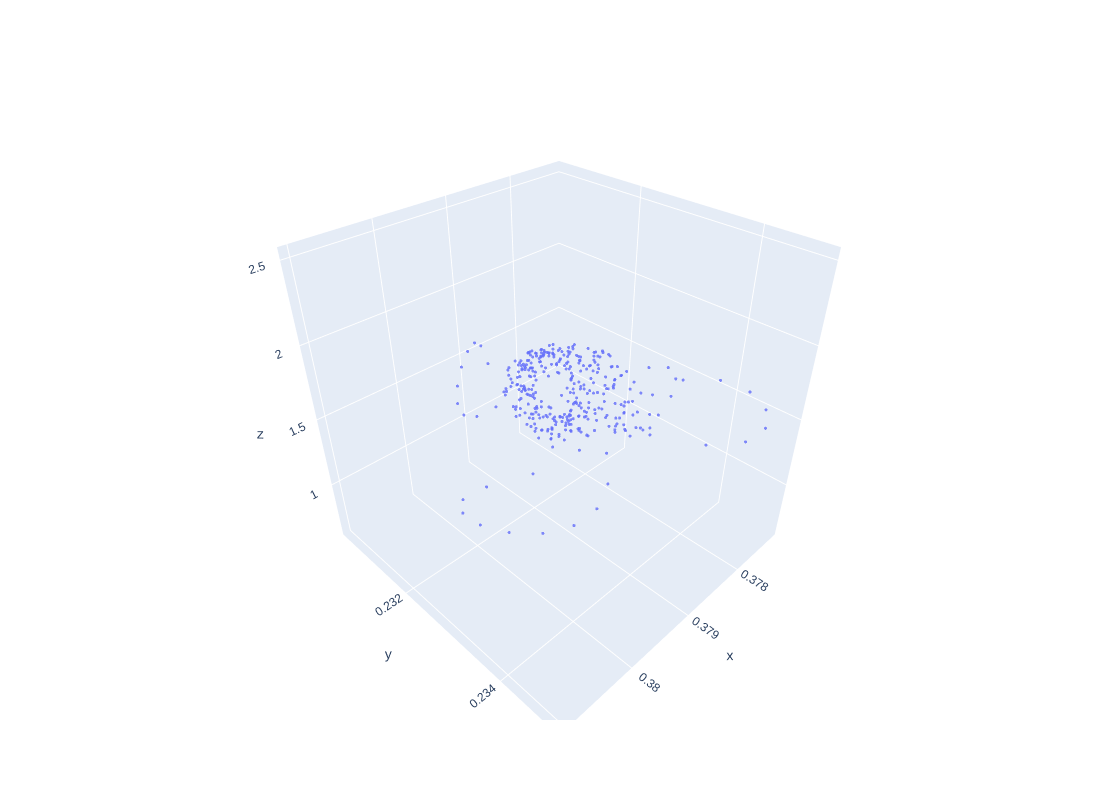

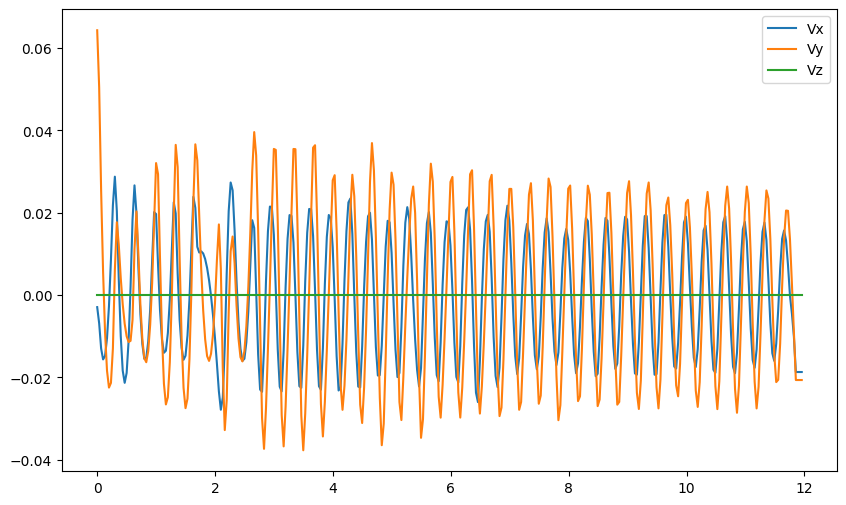

/tmp/ipykernel_67180/441892201.py:51: FutureWarning:

DataFrame.interpolate with method=backfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



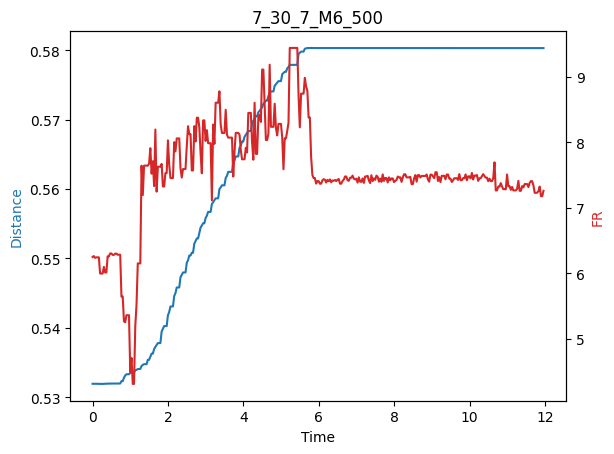

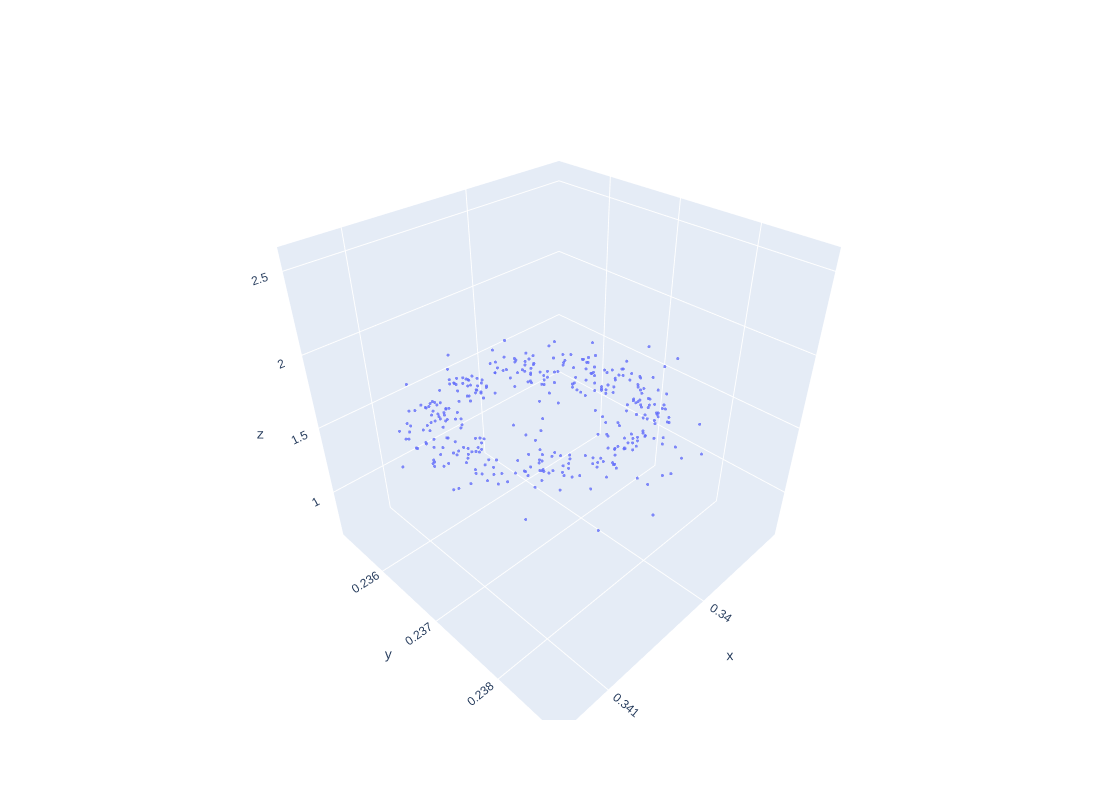

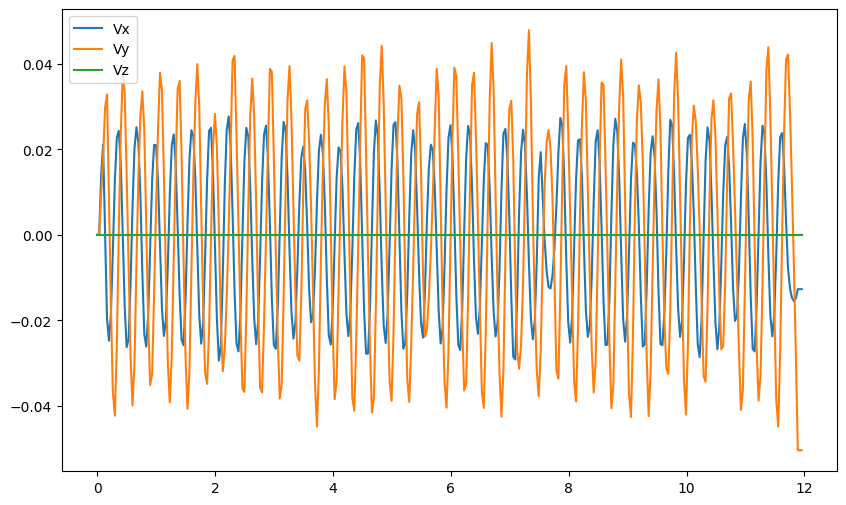

/tmp/ipykernel_67180/441892201.py:51: FutureWarning:

DataFrame.interpolate with method=backfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



21_90_3_M4_2500  doesn't exist
11_60_2_M4_1500  doesn't exist


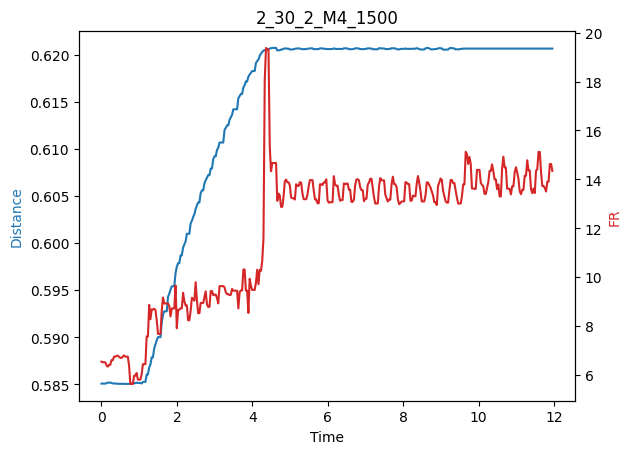

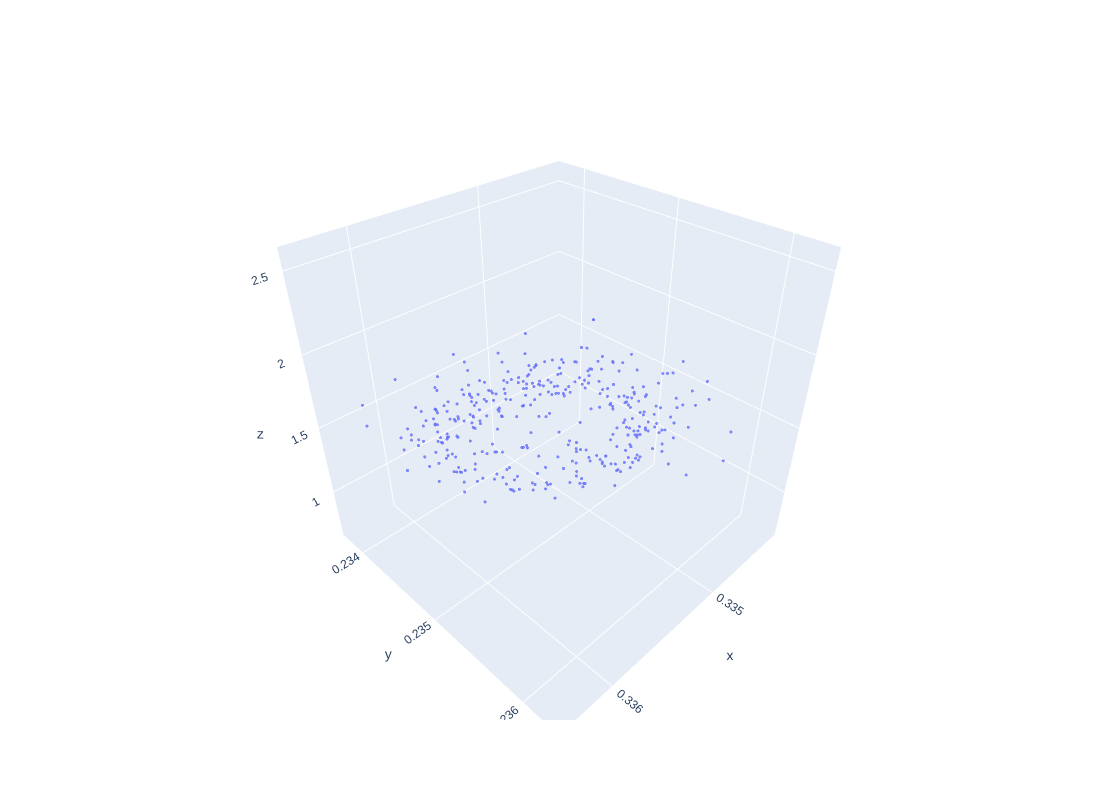

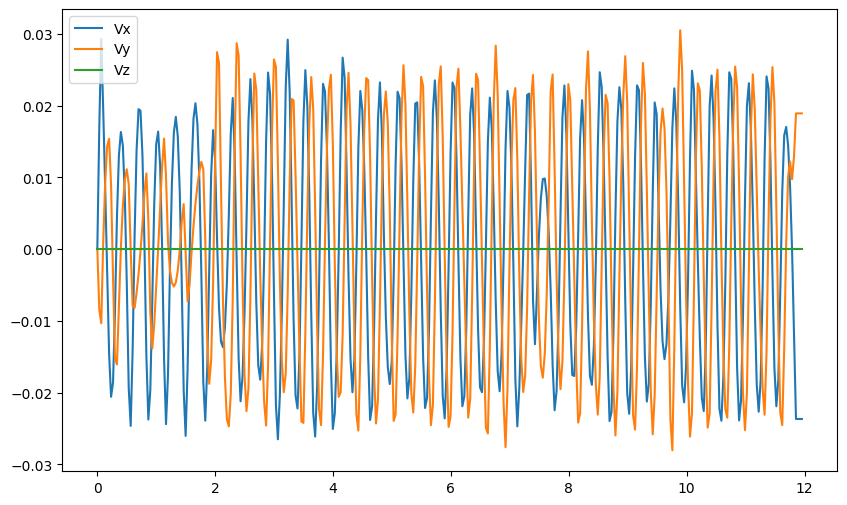

/tmp/ipykernel_67180/441892201.py:51: FutureWarning:

DataFrame.interpolate with method=backfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



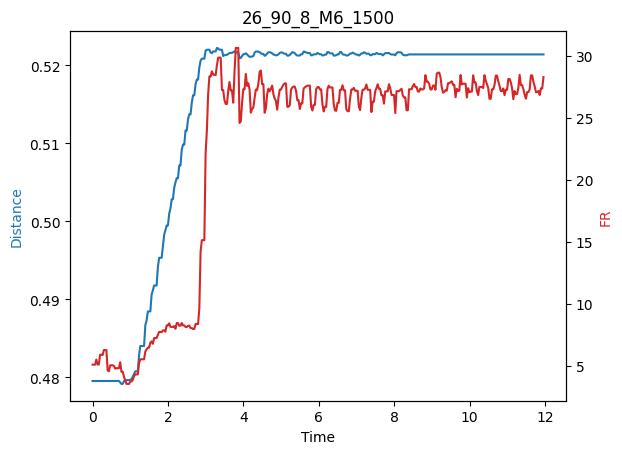

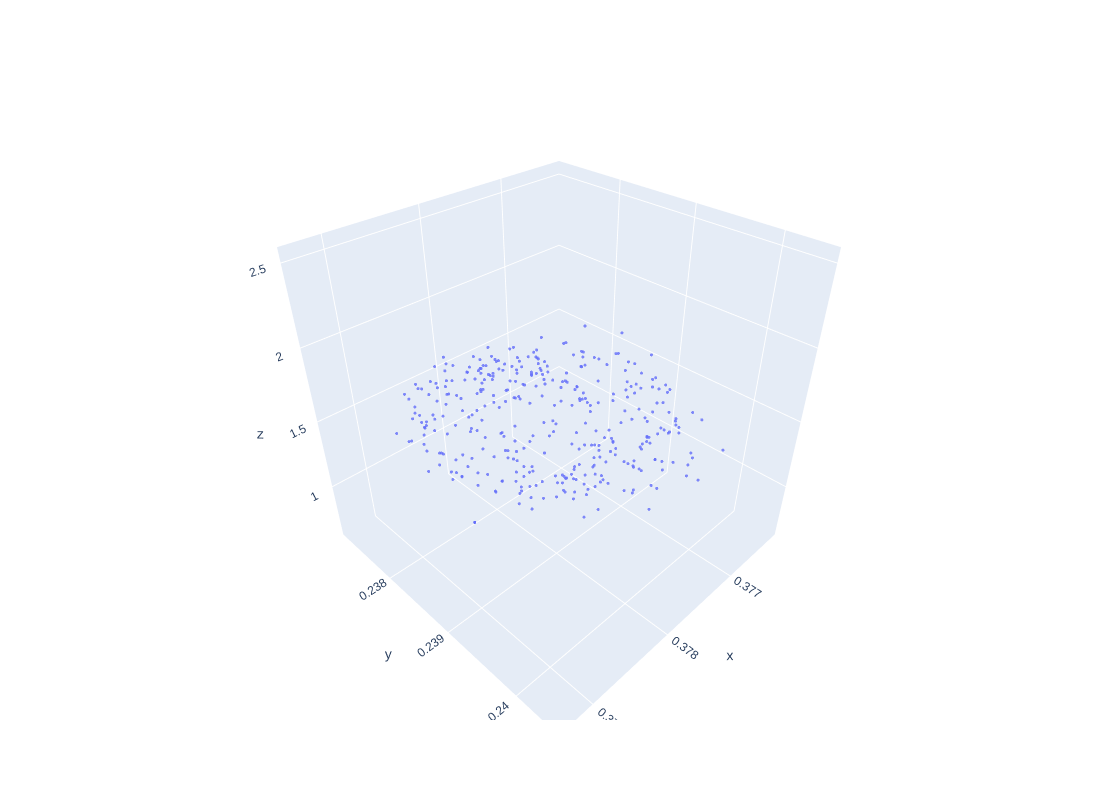

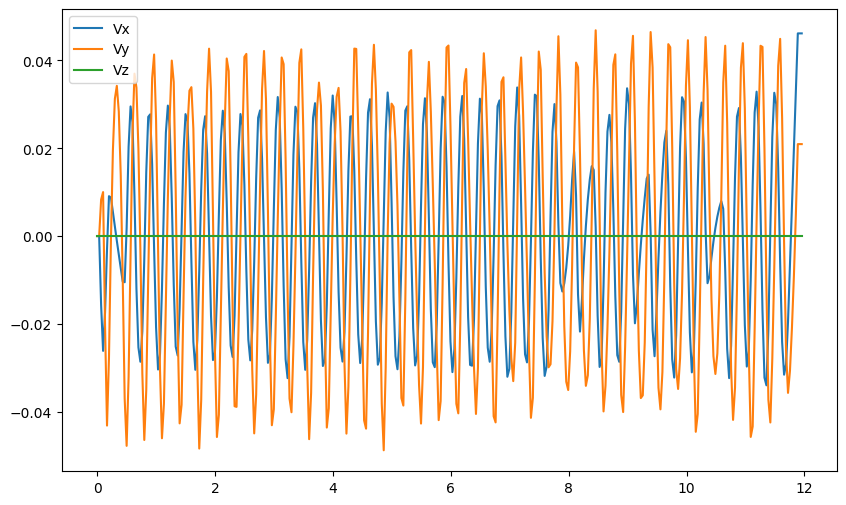

/tmp/ipykernel_67180/441892201.py:51: FutureWarning:

DataFrame.interpolate with method=backfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



4_30_4_M5_500  doesn't exist
20_90_2_M4_1500  doesn't exist


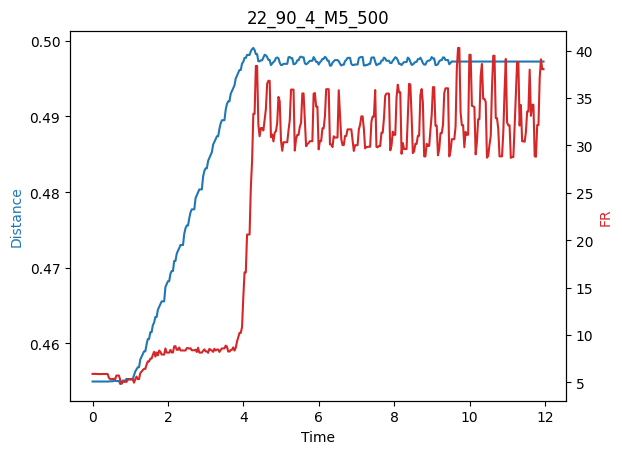

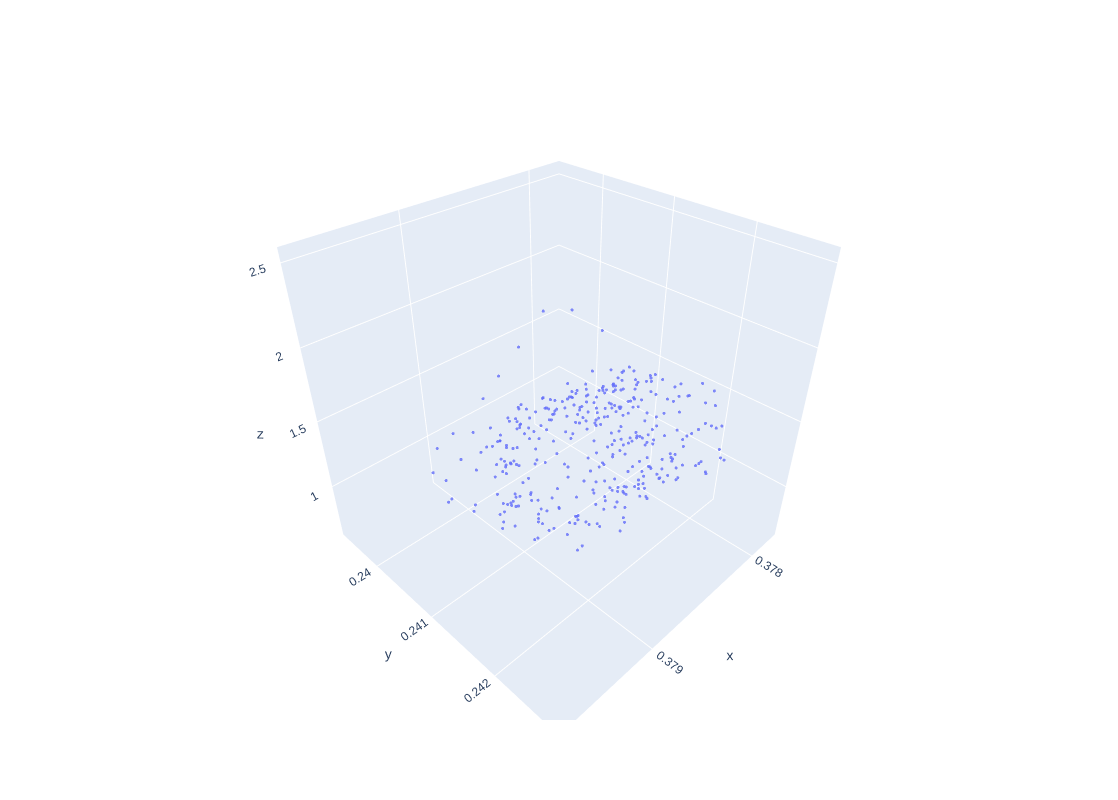

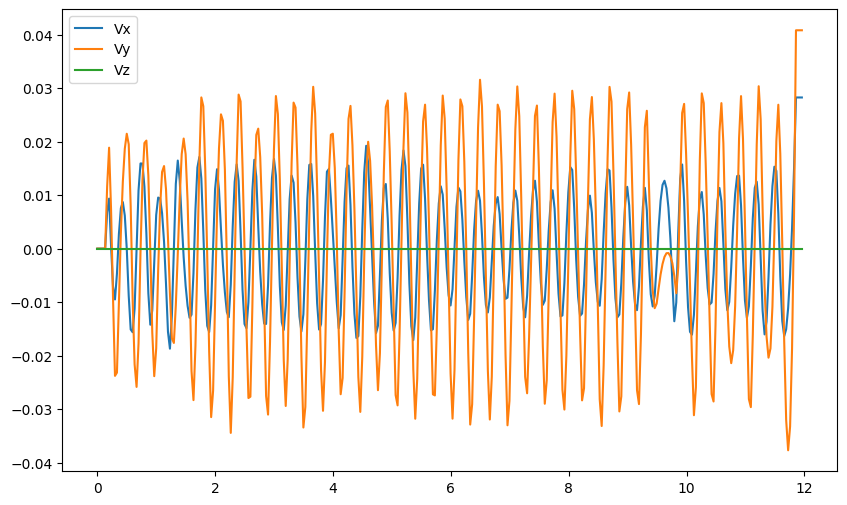

/tmp/ipykernel_67180/441892201.py:51: FutureWarning:

DataFrame.interpolate with method=backfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



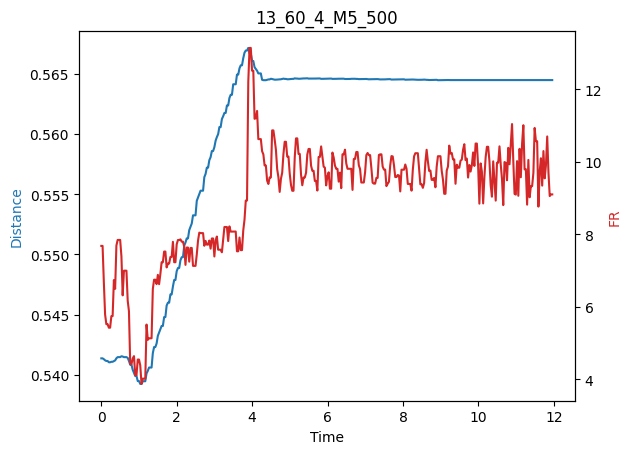

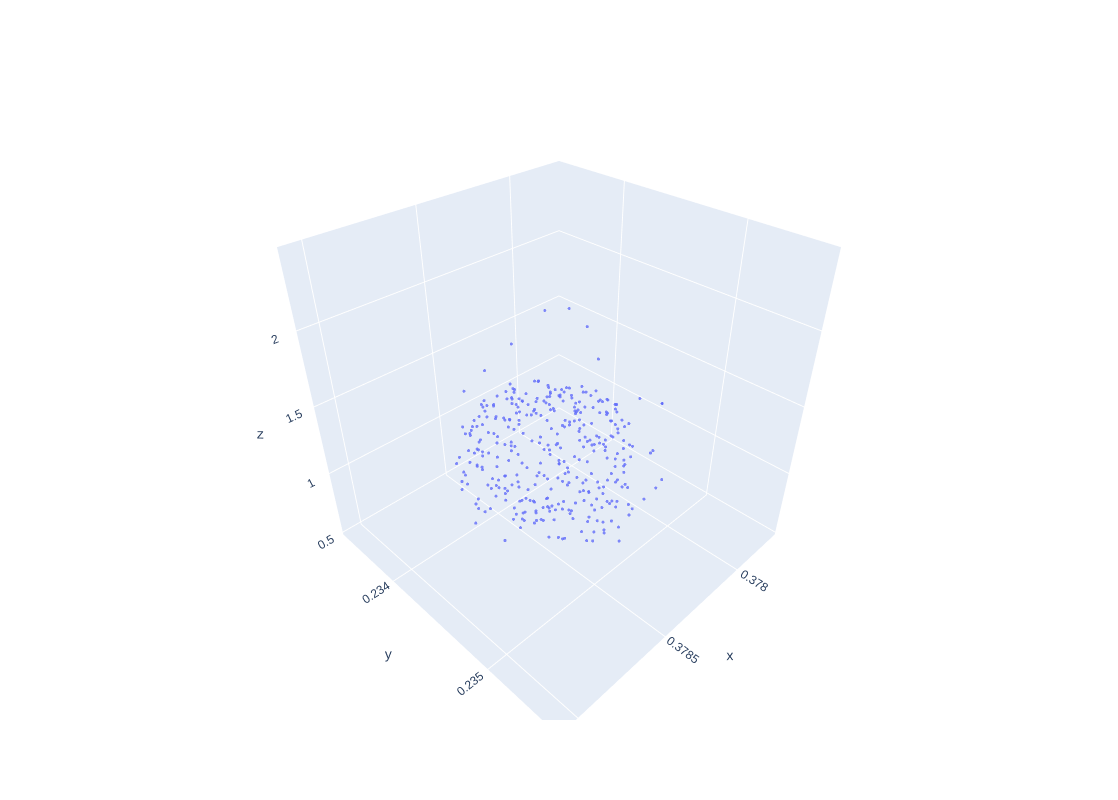

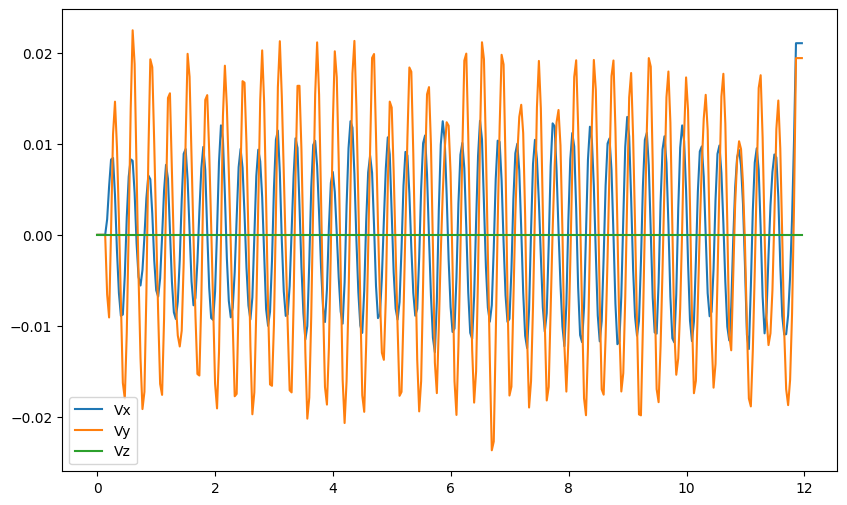

/tmp/ipykernel_67180/441892201.py:51: FutureWarning:

DataFrame.interpolate with method=backfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



10_60_1_M4_500  doesn't exist
23_90_5_M5_1500  doesn't exist


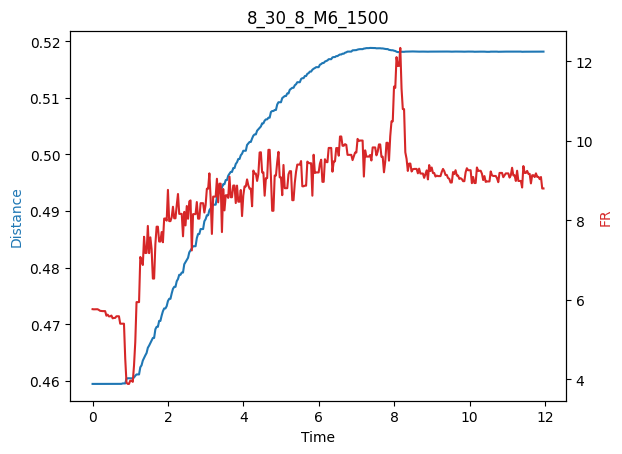

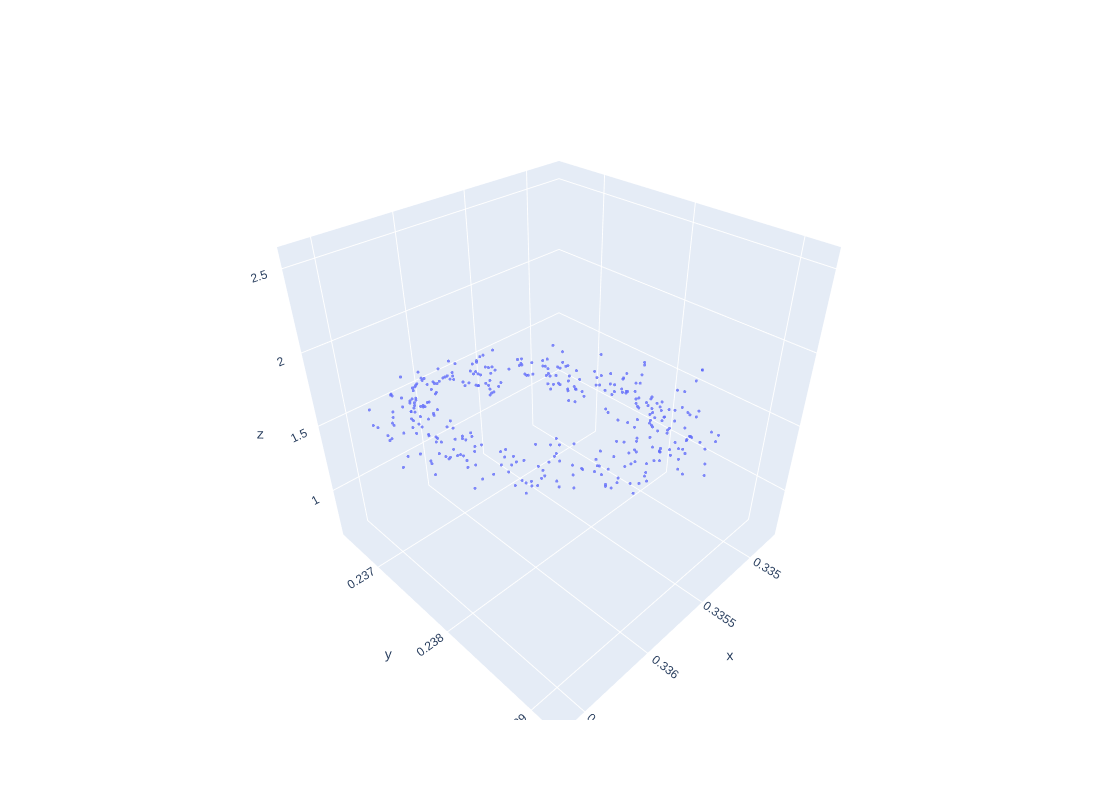

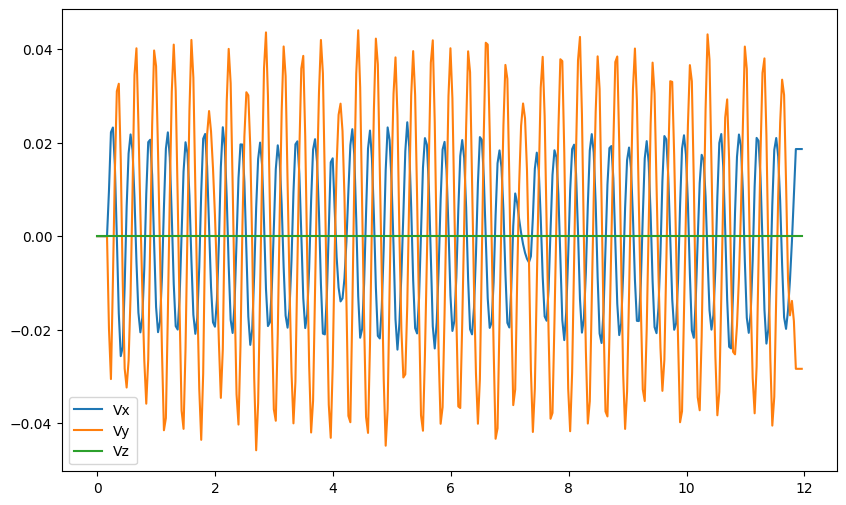

3_30_3_M4_2500  doesn't exist


/tmp/ipykernel_67180/441892201.py:51: FutureWarning:

DataFrame.interpolate with method=backfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



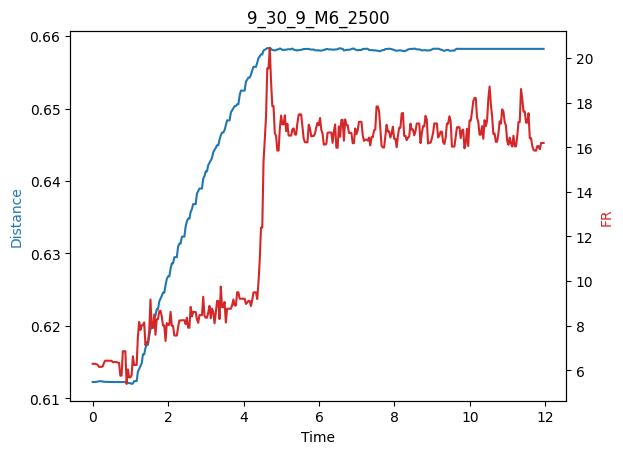

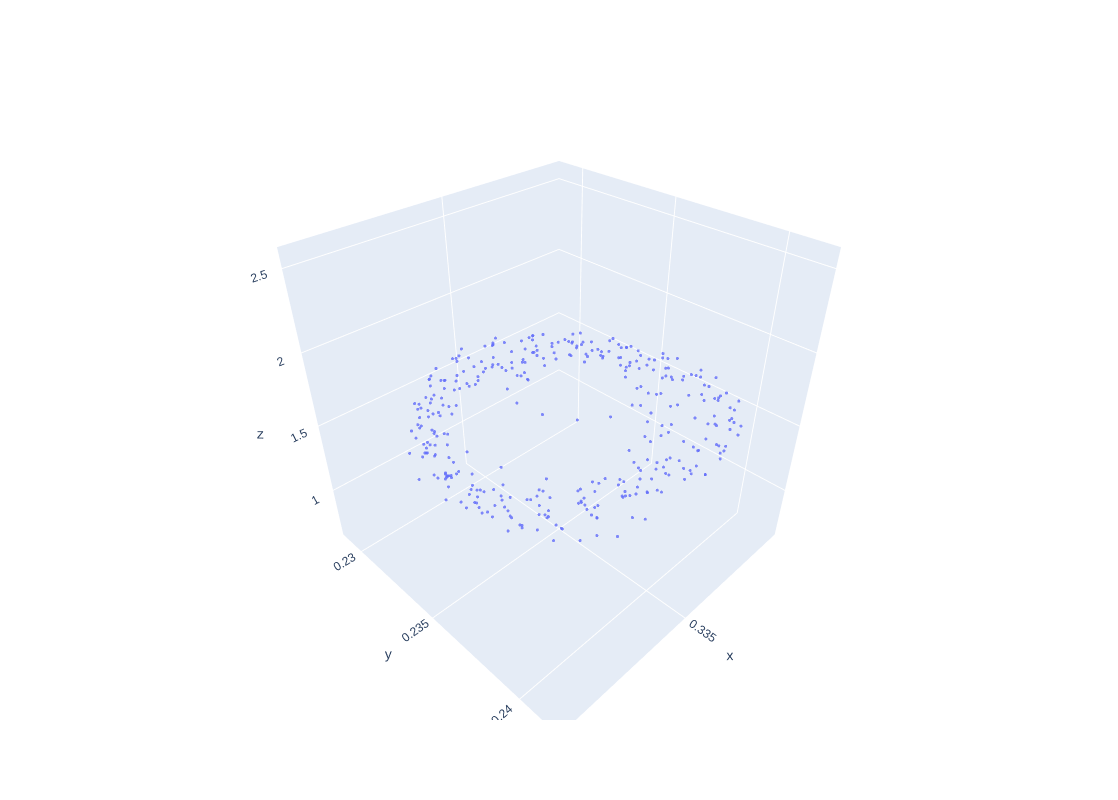

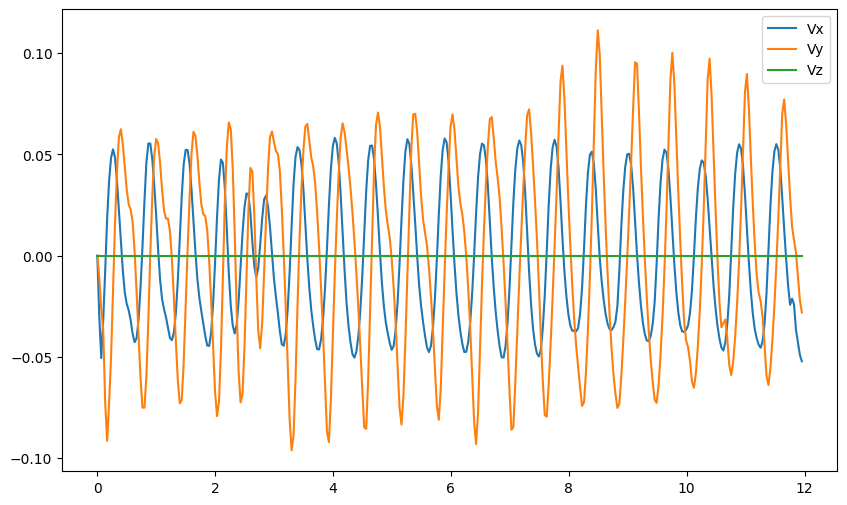

16_60_7_M6_500  doesn't exist


/tmp/ipykernel_67180/441892201.py:51: FutureWarning:

DataFrame.interpolate with method=backfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



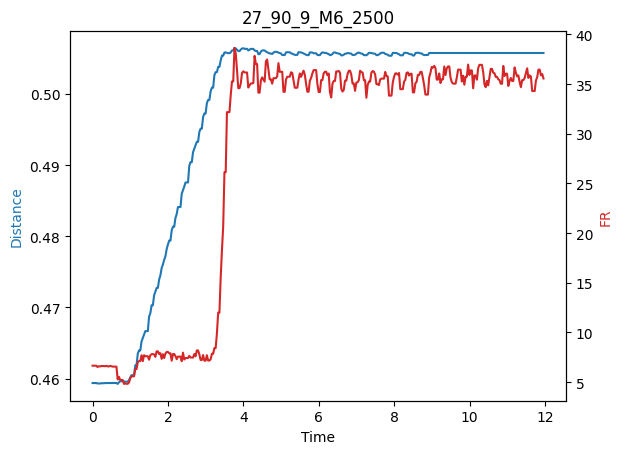

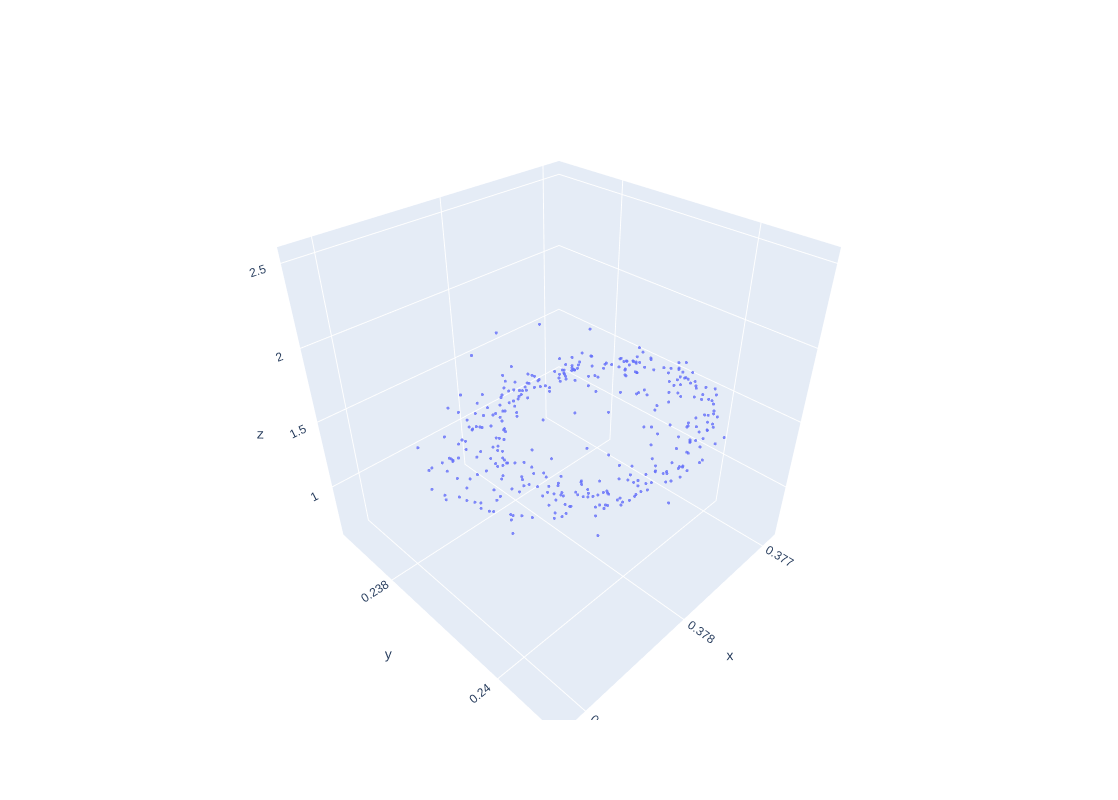

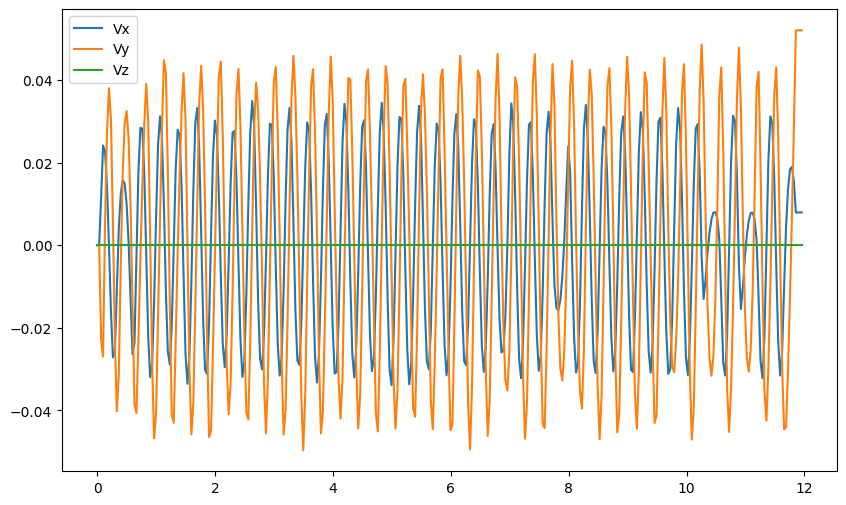

6_30_6_M5_2500  doesn't exist


In [3]:
offset = -0.010  # seconds (sensor is this much time ahead of the camera, minus means behind; manually verified with the image timestamp)
df_list = []

for subdir in subdirs:
    observation_path = os.path.join(obs_data_dir, subdir, observation_file)
    sensor_path = os.path.join(sen_data_dir, subdir, sensor_file)

    if not os.path.exists(observation_path):
        print(subdir, ' doesn\'t exist')
        continue

    obs_df = pd.read_csv(observation_path)
    sen_df = pd.read_csv(sensor_path)
    
    obs_df['time'] = pd.to_datetime(obs_df['time'], unit='ms')
    obs_df = obs_df.sort_values(by='time', ascending=True)
    obs_df['time'] = (obs_df['time'] - obs_df['time'].min()).dt.total_seconds()
    
    sen_df['time'] = pd.to_datetime(sen_df['time'])    
    sen_df['time'] = (sen_df['time'] - sen_df['time'].iloc[0]).dt.total_seconds()
    sen_df['time'] = (sen_df['time'] + offset)

    observation_path_out = os.path.join(obs_data_dir, subdir, 'aligned_{}'.format(observation_file))
    sensor_path_out = os.path.join(obs_data_dir, subdir, 'aligned_{}'.format(sensor_file))
    
    obs_df.to_csv(observation_path_out, index=False)
    sen_df.to_csv(sensor_path_out, index=False)

    sen_df['fr'] = np.sqrt(sen_df['fx'] ** 2 + sen_df['fy'] ** 2 + sen_df['fz'] ** 2)
    sen_df['dist'] = np.sqrt(sen_df['X'] ** 2 + sen_df['Y'] ** 2)
    
    # tp_idx = sen_df[sen_df['dist'] >= sen_df['dist'].max() * 0.9999].index.min()
    # min_after_tp = sen_df['dist'].loc[tp_idx:].min()
    # thresh = 0.10 * min_after_tp
    # tp_idx = sen_df['dist'].loc[tp_idx:].index[sen_df['dist'].loc[tp_idx:] <= min_after_tp + thresh].min()
    # print('screw_init_index: {}'.format(tp_idx))
    # trim_time = sen_df['time'][tp_idx]
    
    merged_df = pd.merge_asof(obs_df, sen_df.drop(columns=['X', 'Y', 'Z']), on='time', tolerance=40, direction='nearest')
    # merged_df = merged_df[merged_df['time'] >= trim_time]
    if merged_df.shape[0] > 0:
        merged_df['X'] = merged_df['X'] / 1000  # norm to meters
        merged_df['Y'] = merged_df['Y'] / 1000  # norm to meters
        merged_df['Z'] = merged_df['Z'] / 1000  # norm to meters
    merged_df.reset_index(drop=True, inplace=True)

    merged_df['Vx'] = np.gradient(merged_df['X'], merged_df['time'])
    merged_df['Vy'] = np.gradient(merged_df['Y'], merged_df['time'])
    merged_df['Vz'] = np.full(merged_df.shape[0], 0)
    merged_df.interpolate(method='linear', axis=0, inplace=True)
    merged_df.interpolate(method='backfill', axis=0, inplace=True)
    
    for column in ['X', 'Y', 'Z']:
        merged_df[column] = merged_df[column].ewm(alpha=0.3).mean()

    fig, ax1 = plt.subplots()
    ax1.plot(merged_df['time'], merged_df['dist'], color='tab:blue')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Distance', color='tab:blue')
    ax2 = ax1.twinx()
    ax2.plot(merged_df['time'], merged_df['fr'], color='tab:red')
    ax2.set_ylabel('FR', color='tab:red')
    plt.title(subdir)
    plt.show()

    fig = go.Figure(data=[go.Scatter3d(
        x=merged_df['X'],
        y=merged_df['Y'],
        z=merged_df['Z'],
        mode='markers',
        marker=dict(
            size=1,
            opacity=0.8
        ),
    )])
    fig.update_layout(width=800, height=800)
    fig.show()

    plt.figure(figsize=(10, 6))  # Adjust size as neede
    plt.plot(merged_df['time'], merged_df['Vx'], label='Vx')
    plt.plot(merged_df['time'], merged_df['Vy'], label='Vy')
    plt.plot(merged_df['time'], merged_df['Vz'], label='Vz')
    plt.legend()
    plt.show()

    merged_path_out = os.path.join(obs_data_dir, subdir, merged_file)
    merged_df.to_csv(merged_path_out, index=False)
    
    df_list.append(merged_df)


In [4]:
combined_df = pd.concat(df_list, ignore_index=True)
combined_df

Unnamed: 0       time         X         Y         Z         A         B  \
0            241   0.000000  0.379798  0.235342  1.579144 -1.419017  1.088597   
1            242   0.033303  0.379798  0.235342  1.579144 -1.419018  1.088597   
2            243   0.066605  0.379798  0.235342  1.579144 -1.419018  1.088597   
3            244   0.099908  0.379977  0.235242  1.579144 -1.419019  1.088597   
4            245   0.133210  0.380190  0.235174  1.579144 -1.419019  1.088597   
...          ...        ...       ...       ...       ...       ...       ...   
4675         596  11.822079  0.377619  0.236996  1.587294 -0.861513  1.518821   
4676         597  11.855382  0.377991  0.237222  1.587294 -0.861513  1.518821   
4677         598  11.888686  0.378282  0.238023  1.587294 -0.861526  1.518820   
4678         599  11.921989  0.378486  0.238584  1.587294 -0.861535  1.518820   
4679         600  11.955290  0.378629  0.238977  1.587294 -0.861533  1.518820   

             C        Vx        Vy  ...  Rot_Cy  Rot_Cz    Kx    Ky    Kz  \
0     0.182994  0.000000  0.000000  ...     0.7     0.7   500   500   500   
1     0.182993  0.000000  0.000000  ...     0.7     0.7   500   500   500   
2     0.182993  0.006805 -0.003827  ...     0.7     0.7   500   500   500   
3     0.182993  0.011571 -0.004324  ...     0.7     0.7   500   500   500   
4     0.182993  0.009447  0.009889  ...     0.7     0.7   500   500   500   
...        ...       ...       ...  ...     ...     ...   ...   ...   ...   
4675  0.623086  0.015521  0.028642  ...     0.7     0.7  2500  2500  2500   
4676  0.623086  0.007941  0.052093  ...     0.7     0.7  2500  2500  2500   
4677  0.623074  0.007941  0.052093  ...     0.7     0.7  2500  2500  2500   
4678  0.623066  0.007941  0.052093  ...     0.7     0.7  2500  2500  2500   
4679  0.623068  0.007941  0.052093  ...     0.7     0.7  2500  2500  2500   

      Rot_Kx  Rot_Ky  Rot_Kz         fr      dist  
0        500     500     500   6.080995  0.540781  
1        500     500     500   6.076416  0.540781  
2        500     500     500   6.085180  0.540781  
3        500     500     500   6.084452  0.540781  
4        500     500     500   6.084452  0.540781  
...      ...     ...     ...        ...       ...  
4675    2500    2500    2500  36.458941  0.505738  
4676    2500    2500    2500  36.458941  0.505738  
4677    2500    2500    2500  35.876890  0.505738  
4678    2500    2500    2500  36.012129  0.505738  
4679    2500    2500    2500  35.567092  0.505738  

[4680 rows x 34 columns]

In [5]:
train_df = combined_df[:-600]
val_df = combined_df[-600:-300]
test_df = combined_df[-300:]

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(train_df.shape, val_df.shape, test_df.shape)

(4080, 34) (300, 34) (300, 34)


In [6]:
os.makedirs(out_dir, exist_ok=True)
train_file_path = os.path.join(out_dir, train_file)
val_file_path = os.path.join(out_dir, validation_file)
test_file_path = os.path.join(out_dir, test_file)

train_df.to_csv(train_file_path, index=False)
val_df.to_csv(val_file_path, index=False)
test_df.to_csv(test_file_path, index=False)